# Footfall Counter

## Overview

This notebook implements a computer vision-based footfall counter system that tracks people entering and exiting a defined region of interest (ROI) in a video. The system uses:

- **YOLO11** for object detection to identify people in video frames
- **BoT-SORT** tracking algorithm to maintain consistent person identities across frames
- **ROI-based counting** to detect when people cross predefined boundaries
- **Debouncing logic** to prevent duplicate counts from the same person

The workflow consists of:
1. Setting up the environment and loading required libraries
2. Defining the video source and region of interest
3. Visualizing the ROI on a sample frame
4. Loading the YOLO11 model for person detection
5. Implementing tracking and counting logic
6. Processing the entire video and generating output with counts
7. Saving the processed video with visual annotations

**Key Features:**
- Real-time person detection and tracking
- Entry/exit counting with visual feedback
- Configurable debounce period to avoid false counts
- Visual ROI overlay and count display
- Video output generation with annotations

## Import required Libraries

This section imports all the essential libraries needed for the footfall counting system:

- **`datetime`**: For timestamp handling and logging
- **`cv2` (OpenCV)**: Core computer vision library for video processing, frame manipulation, and drawing operations
- **`matplotlib.pyplot`**: For displaying images and visualizations in the notebook
- **`IPython.display`**: For rendering videos and interactive content within Jupyter notebooks
- **`ultralytics.YOLO`**: The YOLO11 model for state-of-the-art object detection and tracking
- **`%matplotlib inline`**: Magic command to display plots directly in notebook cells

In [1]:
from datetime import datetime

import cv2
import matplotlib.pyplot as plt
from IPython.display import Video, display
from ultralytics import YOLO

%matplotlib inline

## Define Video Path and Region of Interest (ROI)

Here we define the core parameters for our footfall counting system:

- **`video_path`**: Path to the input video file that will be analyzed for people counting
- **`video_roi`**: Region of Interest coordinates defined as `(x1, y1, x2, y2)` tuple
  - `(x1, y1)`: Top-left corner of the rectangular ROI
  - `(x2, y2)`: Bottom-right corner of the rectangular ROI
  - People crossing this boundary will trigger entry/exit events
  - The ROI should be positioned at doorways, gates, or other entry/exit points

In [2]:
video_path = "../data/853874-hd_1920_1080_25fps.mp4"
video_roi = (400, 713, 826, 718)

## Visualize ROI on a Video Frame

This section visualizes the Region of Interest (ROI) on a sample frame to verify correct positioning:

**Process:**
1. **Video Loading**: Opens the video file and gets total frame count
2. **Frame Selection**: Chooses a representative frame (frame 100 or middle frame if video is shorter)
3. **Frame Extraction**: Retrieves the selected frame from the video
4. **ROI Drawing**: Overlays a green line on the frame to show the counting boundary
5. **Visualization**: Displays the frame with ROI using matplotlib

**Purpose:**
- Verify that the ROI is positioned correctly over the entry/exit area
- Ensure the ROI covers the appropriate region for person detection
- Visual confirmation before running the full counting algorithm

The green line represents where the system will detect people crossing for entry/exit counting.

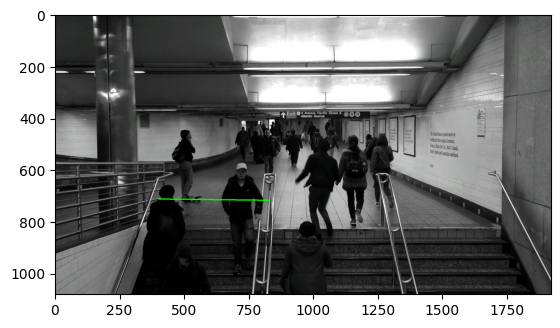

In [3]:
cap = cv2.VideoCapture(video_path)

# Get total frame count and select a middle frame
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
if total_frames == 0:
    raise ValueError("Video has no frames or frame count could not be determined")
visualization_frame = min(100, total_frames // 2)

# Grab a frame (e.g., 100th frame)
cap.set(cv2.CAP_PROP_POS_FRAMES, visualization_frame)
ret, frame = cap.read()
cap.release()

# Draw ROI on Visualization Frame
frame = cv2.line(frame, video_roi[:2], video_roi[2:], (0, 255, 0), 3)

# Show Visualized ROI
plt.imshow(frame)

## Load YOLO11 Model

This step initializes the YOLO11 model for object detection:

**Model Details:**
- **`yolo11n.pt`**: The nano version of YOLO11 - smallest and fastest variant
- **Purpose**: Detects and classifies objects in video frames, specifically people (class 0)
- **Performance**: Optimized for real-time processing with good accuracy-speed balance

**Why YOLO11n:**
- Fast inference suitable for video processing
- Good accuracy for person detection
- Lower computational requirements
- Automatic model download if not present locally

The model will be used in the next steps to detect people in each video frame before tracking them.

In [4]:
model = YOLO("yolo11n.pt")

## Perfom Object Detection and Tracking of Persons

This section sets up the object detection and tracking pipeline:

**Configuration Parameters:**
- **`source=video_path`**: Input video file to process
- **`classes=[0]`**: Filter to detect only people (class 0 in COCO dataset)
- **`conf=0.5`**: Confidence threshold - only detections above 50% confidence are kept
- **`tracker="../botsort.yaml"`**: BoT-SORT tracking configuration file
- **`batch=1`**: Process one frame at a time for real-time tracking
- **`stream=True`**: Enable streaming mode for memory-efficient processing

**BoT-SORT Tracker:**
- Advanced multi-object tracking algorithm
- Maintains consistent IDs for people across frames
- Handles occlusions and temporary disappearances
- Essential for accurate entry/exit counting

The `track_generator` creates a stream of tracking results that will be processed frame by frame.

## FootfallTracker Class Implementation

This section implements the core `FootfallTracker` class that handles the counting logic:

**Key Components:**

1. **Configuration**:
   - `DEBOUNCE_FRAMES = 50`: Prevents duplicate counts (approximately 2 seconds at 25fps)
   - `frames_array = []`: Stores processed frames for video output

2. **Class Attributes**:
   - `roi`: Region of interest coordinates
   - `entry_count` & `exit_count`: Running totals of people entering/exiting
   - `tracked_objects`: Dictionary storing last known position and ROI status for each person
   - `recent_events`: Debouncing mechanism to prevent duplicate counts

3. **Core Methods**:
   - `is_crossing_line()`: Checks if a person's center point and bounding box are within the ROI
   - `should_count_event()`: Implements debouncing logic to prevent false counts
   - `process_detections()`: Extracts person positions from YOLO tracking results
   - `check_crossings()`: Detects entry/exit events by comparing current and previous positions
   - `draw_roi()`, `draw_counts()`, `draw_event_text()`: Visual annotation methods
   - `process_frame()`: Main method that processes each frame and updates counts

**Counting Logic:**
- **Entry**: Person moves from outside ROI to inside ROI
- **Exit**: Person moves from inside ROI to outside ROI
- **Debouncing**: Same person cannot trigger another count for 349 frames (prevents oscillation)

In [5]:
# Configuration
DEBOUNCE_FRAMES = 50
frames_array = []


class FootfallTracker:
    """Footfall tracking using a line ROI."""

    def __init__(self, line_coords, debounce_frames=10):
        """
        line_coords: (x1, y1, x2, y2) for the ROI line
        """
        self.line = line_coords
        self.debounce_frames = debounce_frames
        self.entry_count = 0
        self.exit_count = 0
        self.tracked_objects = {}
        self.recent_events = {}
        self.frame_number = 0

    def is_crossing_line(self, prev_box, curr_box, prev_center, curr_center):
        """Check if any part of the bounding box crossed the line."""
        x1, y1, x2, y2 = self.line

        # Center if center crosses line
        def side(px, py):
            return (y2 - y1) * px - (x2 - x1) * py + (x2 * y1 - x1 * y2)

        prev_side = side(*prev_center)
        curr_side = side(*curr_center)
        center_cross = 0
        if prev_side != 0 and curr_side != 0 and prev_side * curr_side < 0:
            center_cross = 1 if prev_side < curr_side else -1  # 1: entry, -1: exit

        # Check if line intersects with the bbox edges
        def bbox_edges(box):
            x1, y1, x2, y2 = box
            return [
                ((x1, y1), (x2, y1)),  # top
                ((x2, y1), (x2, y2)),  # right
                ((x2, y2), (x1, y2)),  # bottom
                ((x1, y2), (x1, y1)),  # left
            ]

        def line_intersect(p1, p2, q1, q2):
            """Return True if lines (p1-p2) and (q1-q2) intersect"""

            def ccw(A, B, C):
                return (C[1] - A[1]) * (B[0] - A[0]) > (B[1] - A[1]) * (C[0] - A[0])

            return ccw(p1, q1, q2) != ccw(p2, q1, q2) and ccw(p1, p2, q1) != ccw(
                p1, p2, q2
            )

        prev_cross = any(
            line_intersect((x1, y1), (x2, y2), e[0], e[1]) for e in bbox_edges(prev_box)
        )
        curr_cross = any(
            line_intersect((x1, y1), (x2, y2), e[0], e[1]) for e in bbox_edges(curr_box)
        )
        bbox_cross = (
            (not prev_cross and curr_cross)
            or (prev_cross and not curr_cross)
            or (prev_cross and curr_cross)
        )

        if center_cross != 0 and bbox_cross:
            return center_cross
        return 0

    def should_count_event(self, track_id, event_type):
        if track_id not in self.recent_events:
            return True
        frames_since_last = self.frame_number - self.recent_events[track_id]["frame"]
        return frames_since_last > self.debounce_frames

    def record_event(self, track_id, event_type):
        self.recent_events[track_id] = {"type": event_type, "frame": self.frame_number}

    def draw_roi(self, frame):
        x1, y1, x2, y2 = self.line
        return cv2.line(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

    def draw_event_text(self, frame, text, center_x, center_y, color):
        return cv2.putText(
            frame,
            text,
            (center_x - 30, center_y - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.7,
            color,
            2,
        )

    def draw_counts(self, frame):
        frame = cv2.putText(
            frame,
            f"Entries: {self.entry_count}",
            (10, 30),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            (0, 255, 0),
            2,
        )
        frame = cv2.putText(
            frame,
            f"Exits: {self.exit_count}",
            (10, 70),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            (0, 0, 255),
            2,
        )
        return frame

    def process_detections(self, tracks):
        if tracks.boxes is None or tracks.boxes.id is None:
            return []
        person_boxes = tracks.boxes.xyxy.cpu().numpy()
        track_ids = tracks.boxes.id.cpu().numpy()

        detections = []
        for i, track_id in enumerate(track_ids):
            x1, y1, x2, y2 = person_boxes[i]
            center_x = int((x1 + x2) / 2)
            center_y = int((y1 + y2) / 2)
            detections.append(
                {
                    "track_id": int(track_id),
                    "center": (center_x, center_y),
                    "bbox": (int(x1), int(y1), int(x2), int(y2)),
                }
            )
        return detections

    def check_crossings(self, detection, frame):
        track_id = detection["track_id"]
        center = detection["center"]
        bbox = detection["bbox"]

        if track_id in self.tracked_objects:
            prev_bbox, prev_center = self.tracked_objects[track_id]

            crossing = self.is_crossing_line(prev_bbox, bbox, prev_center, center)

            if crossing == 1 and self.should_count_event(track_id, "exit"):
                self.exit_count += 1
                self.record_event(track_id, "exit")
                frame = self.draw_event_text(frame, "EXIT", *center, (0, 0, 255))
            elif crossing == -1 and self.should_count_event(track_id, "entry"):
                self.entry_count += 1
                self.record_event(track_id, "entry")
                frame = self.draw_event_text(frame, "ENTRY", *center, (0, 255, 0))

        self.tracked_objects[track_id] = (bbox, center)
        return frame

    def process_frame(self, tracks):
        self.frame_number += 1
        frame = tracks.plot()
        frame = self.draw_roi(frame)
        detections = self.process_detections(tracks)
        for detection in detections:
            frame = self.check_crossings(detection, frame)
        frame = self.draw_counts(frame)
        return frame

In [6]:
track_generator = model.track(
    source=video_path,
    classes=[0],
    conf=0.5,
    tracker="../botsort.yaml",
    batch=1,
    stream=True,
)

## Main Processing Loop

This is the core execution section that processes the entire video:

**Process Flow:**
1. **Tracker Initialization**: Creates a `FootfallTracker` instance with the defined ROI and debounce settings
2. **Frame-by-Frame Processing**: Iterates through each frame from the YOLO tracking generator
3. **Frame Processing**: For each frame:
   - Applies object detection and tracking
   - Checks for people crossing the ROI boundary
   - Updates entry/exit counts
   - Draws visual annotations (ROI, counts, entry/exit labels)
   - Stores the processed frame for video output
4. **Results**: Prints final entry and exit counts

**What Happens Per Frame:**
- YOLO detects people and assigns tracking IDs
- System checks if each person is inside or outside the ROI
- Compares with previous frame to detect boundary crossings
- Updates counters when valid entry/exit events are detected
- Adds visual feedback (green "ENTRY", red "EXIT" text)
- Displays running totals on the frame

**Output**: 
- Console output showing final counts
- `frames_array` containing all processed frames with annotations

In [7]:
# Initialize tracker
tracker = FootfallTracker(video_roi, DEBOUNCE_FRAMES)

# Process all frames
for tracks in track_generator:
    processed_frame = tracker.process_frame(tracks)
    frames_array.append(processed_frame)

print(f"Final counts - Entries: {tracker.entry_count}, Exits: {tracker.exit_count}")


video 1/1 (frame 1/349) /Users/shrijeet/persona/Footfall-Counter-using-Computer-Vision/notebooks/../data/853874-hd_1920_1080_25fps.mp4: 384x640 12 persons, 47.9ms
video 1/1 (frame 2/349) /Users/shrijeet/persona/Footfall-Counter-using-Computer-Vision/notebooks/../data/853874-hd_1920_1080_25fps.mp4: 384x640 12 persons, 54.4ms
video 1/1 (frame 3/349) /Users/shrijeet/persona/Footfall-Counter-using-Computer-Vision/notebooks/../data/853874-hd_1920_1080_25fps.mp4: 384x640 11 persons, 45.0ms
video 1/1 (frame 4/349) /Users/shrijeet/persona/Footfall-Counter-using-Computer-Vision/notebooks/../data/853874-hd_1920_1080_25fps.mp4: 384x640 11 persons, 45.7ms
video 1/1 (frame 5/349) /Users/shrijeet/persona/Footfall-Counter-using-Computer-Vision/notebooks/../data/853874-hd_1920_1080_25fps.mp4: 384x640 12 persons, 45.1ms
video 1/1 (frame 6/349) /Users/shrijeet/persona/Footfall-Counter-using-Computer-Vision/notebooks/../data/853874-hd_1920_1080_25fps.mp4: 384x640 11 persons, 44.0ms
video 1/1 (frame 7/34

## Video Output Generation

This section creates and saves the processed video with all annotations:

**Helper Functions:**

1. **`get_video_fps()`**: Extracts the original frame rate from the input video to maintain consistent playback speed

2. **`save_frames_as_video()`**: Converts the processed frame array into an MP4 video file
   - **Parameters**: 
     - `frames_array`: All processed frames with annotations
     - `output_path`: Destination file path with timestamp
     - `fps`: Frame rate (matches original video)
   - **Process**:
     - Sets up H.264 codec for efficient compression
     - Creates VideoWriter with original dimensions and frame rate
     - Converts RGB frames to BGR (OpenCV format)
     - Writes each frame to the output video file

**Output Generation:**
- **Filename**: Timestamped filename (e.g., `tracking_output_20241021_123045.mp4`)
- **Content**: Complete video with:
  - Original video content
  - Green ROI boundary rectangle
  - Person detection bounding boxes with tracking IDs
  - Entry/exit event labels ("ENTRY" in green, "EXIT" in red)
  - Real-time entry and exit counters
- **Display**: Embedded video player in the notebook for immediate viewing

**Result**: A comprehensive video showing the entire footfall counting process with visual feedback for verification and analysis.

In [8]:
def get_video_fps(video_path):
    """Read FPS from input video."""
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    cap.release()
    # Default fallback if FPS cannot be read
    return int(fps) if fps and fps > 0 else 25


# Save frames as MP4 video
def save_frames_as_video(frames_array, output_path="tracking_video.mp4", fps=25):
    fps = get_video_fps(video_path) if video_path else 25
    height, width = frames_array[0].shape[:2]
    fourcc = cv2.VideoWriter_fourcc(*"H264")
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    for frame in frames_array:
        out.write(frame)

    out.release()
    return output_path


# Save and display
input_video_path = f"tracking_output_{datetime.now().strftime('%Y%m%d_%H%M%S')}.mp4"
tracked_video_path = save_frames_as_video(frames_array, input_video_path, fps=25)
display(Video(filename=tracked_video_path))

OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'
